In [1]:
# Import related packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import math


In [66]:
# Import trainset and testset
project_dir = '../House Price/'
trainset = pd.read_csv(project_dir + 'train.csv')
testset = pd.read_csv(project_dir + 'test.csv')

In [3]:
trainset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Check the number of rows and columns in the trainset
print(f'There are {trainset.shape[0]} rows and {trainset.shape[1]} columns in the trainset.')

There are 1460 rows and 81 columns in the trainset.


In [5]:
# Print the column with missing value
missing_values = trainset.isnull().sum().sort_values(ascending=False)
for column, missing in missing_values.items():
    if missing != 0:
        print(f'{column}: {missing}, {missing/trainset.shape[0]*100:.2f}% missing.')

PoolQC: 1453, 99.52% missing.
MiscFeature: 1406, 96.30% missing.
Alley: 1369, 93.77% missing.
Fence: 1179, 80.75% missing.
MasVnrType: 872, 59.73% missing.
FireplaceQu: 690, 47.26% missing.
LotFrontage: 259, 17.74% missing.
GarageYrBlt: 81, 5.55% missing.
GarageCond: 81, 5.55% missing.
GarageType: 81, 5.55% missing.
GarageFinish: 81, 5.55% missing.
GarageQual: 81, 5.55% missing.
BsmtFinType2: 38, 2.60% missing.
BsmtExposure: 38, 2.60% missing.
BsmtQual: 37, 2.53% missing.
BsmtCond: 37, 2.53% missing.
BsmtFinType1: 37, 2.53% missing.
MasVnrArea: 8, 0.55% missing.
Electrical: 1, 0.07% missing.


In [6]:
# Drop columns with lots of missing values
trainset.drop(['Id', 'Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis = 1, inplace = True)

In [7]:
# Fill na with mean for numerical columns and with mode for categorical columns
for column in trainset.columns:
    if trainset[column].dtype == 'object':
        trainset[column] = trainset[column].fillna(trainset[column].mode()[0])
    else:
        trainset[column] = trainset[column].fillna(trainset[column].mean())

In [8]:
# Check if there is still missing value
missing_values = trainset.isnull().sum().sort_values(ascending=False)
for column, missing in missing_values.items():
    print(f'{column}: {missing}, {missing/trainset.shape[0]*100:.2f}% missing.')

MSSubClass: 0, 0.00% missing.
GarageYrBlt: 0, 0.00% missing.
Fireplaces: 0, 0.00% missing.
Functional: 0, 0.00% missing.
TotRmsAbvGrd: 0, 0.00% missing.
KitchenQual: 0, 0.00% missing.
KitchenAbvGr: 0, 0.00% missing.
BedroomAbvGr: 0, 0.00% missing.
HalfBath: 0, 0.00% missing.
FullBath: 0, 0.00% missing.
BsmtHalfBath: 0, 0.00% missing.
BsmtFullBath: 0, 0.00% missing.
GrLivArea: 0, 0.00% missing.
LowQualFinSF: 0, 0.00% missing.
2ndFlrSF: 0, 0.00% missing.
1stFlrSF: 0, 0.00% missing.
Electrical: 0, 0.00% missing.
GarageType: 0, 0.00% missing.
GarageFinish: 0, 0.00% missing.
MSZoning: 0, 0.00% missing.
GarageCars: 0, 0.00% missing.
SaleCondition: 0, 0.00% missing.
SaleType: 0, 0.00% missing.
YrSold: 0, 0.00% missing.
MoSold: 0, 0.00% missing.
MiscVal: 0, 0.00% missing.
PoolArea: 0, 0.00% missing.
ScreenPorch: 0, 0.00% missing.
3SsnPorch: 0, 0.00% missing.
EnclosedPorch: 0, 0.00% missing.
OpenPorchSF: 0, 0.00% missing.
WoodDeckSF: 0, 0.00% missing.
PavedDrive: 0, 0.00% missing.
GarageCond: 0

In [9]:
trainset.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


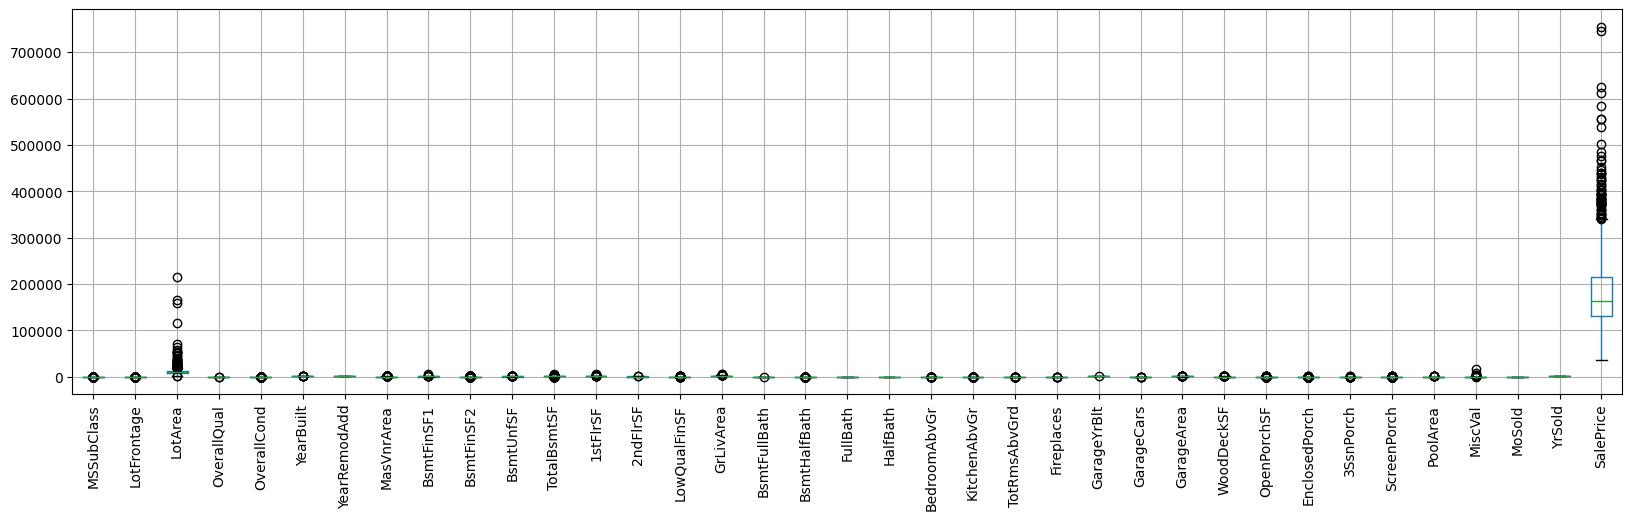

In [10]:
# Draw boxplots for each numerical feature
trainset.boxplot(figsize=(20,5))
plt.xticks(rotation='vertical')
plt.show()

In [11]:
# Handle outliers for columns SalePrice and LotArea
Q1 = trainset.SalePrice.quantile(0.25)
Q3 = trainset.SalePrice.quantile(0.75)
IQR = Q3- Q1
trainset = trainset[(trainset.SalePrice >= (Q1 - 1.5*IQR)) & (trainset.SalePrice <= (Q3 + 1.5*IQR))]

Q1 = trainset.LotArea.quantile(0.25)
Q3 = trainset.LotArea.quantile(0.75)
IQR = Q3- Q1
trainset = trainset[(trainset.LotArea >= (Q1 - 1.5*IQR)) & (trainset.LotArea <= (Q3 + 1.5*IQR))]

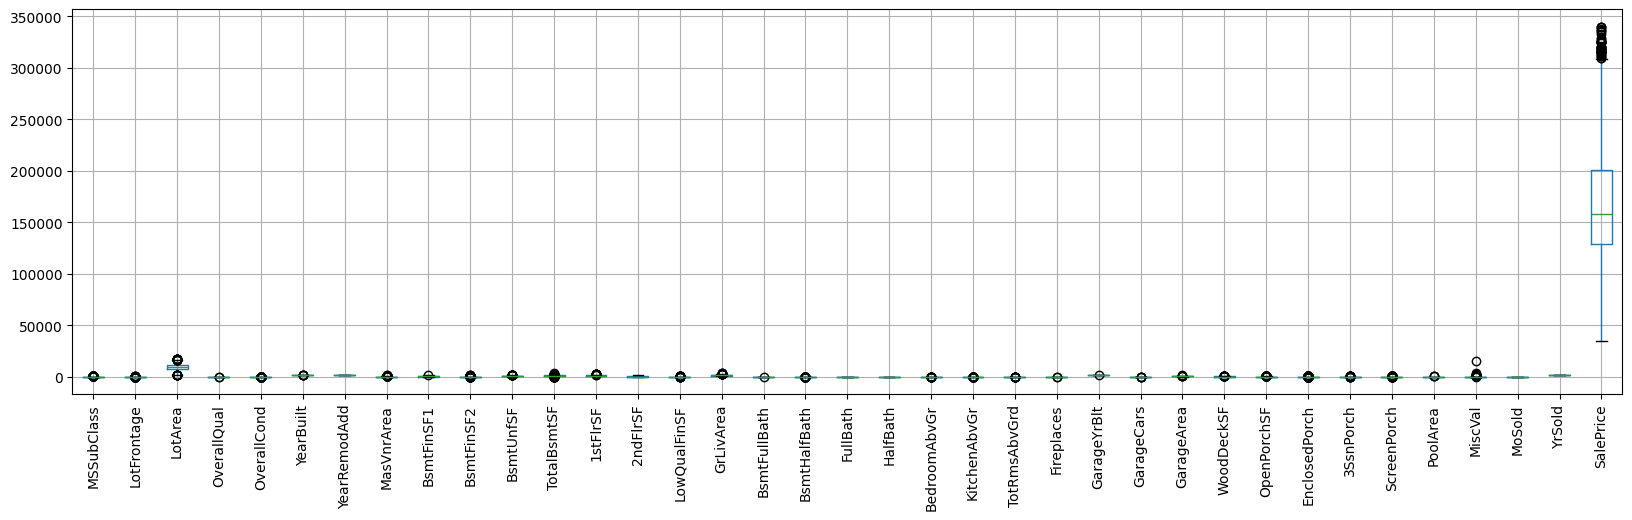

In [12]:
# Check the result of handling outliers
trainset.boxplot(figsize=(20,5))
plt.xticks(rotation='vertical')
plt.show()

In [13]:
trainset.shape

(1326, 74)

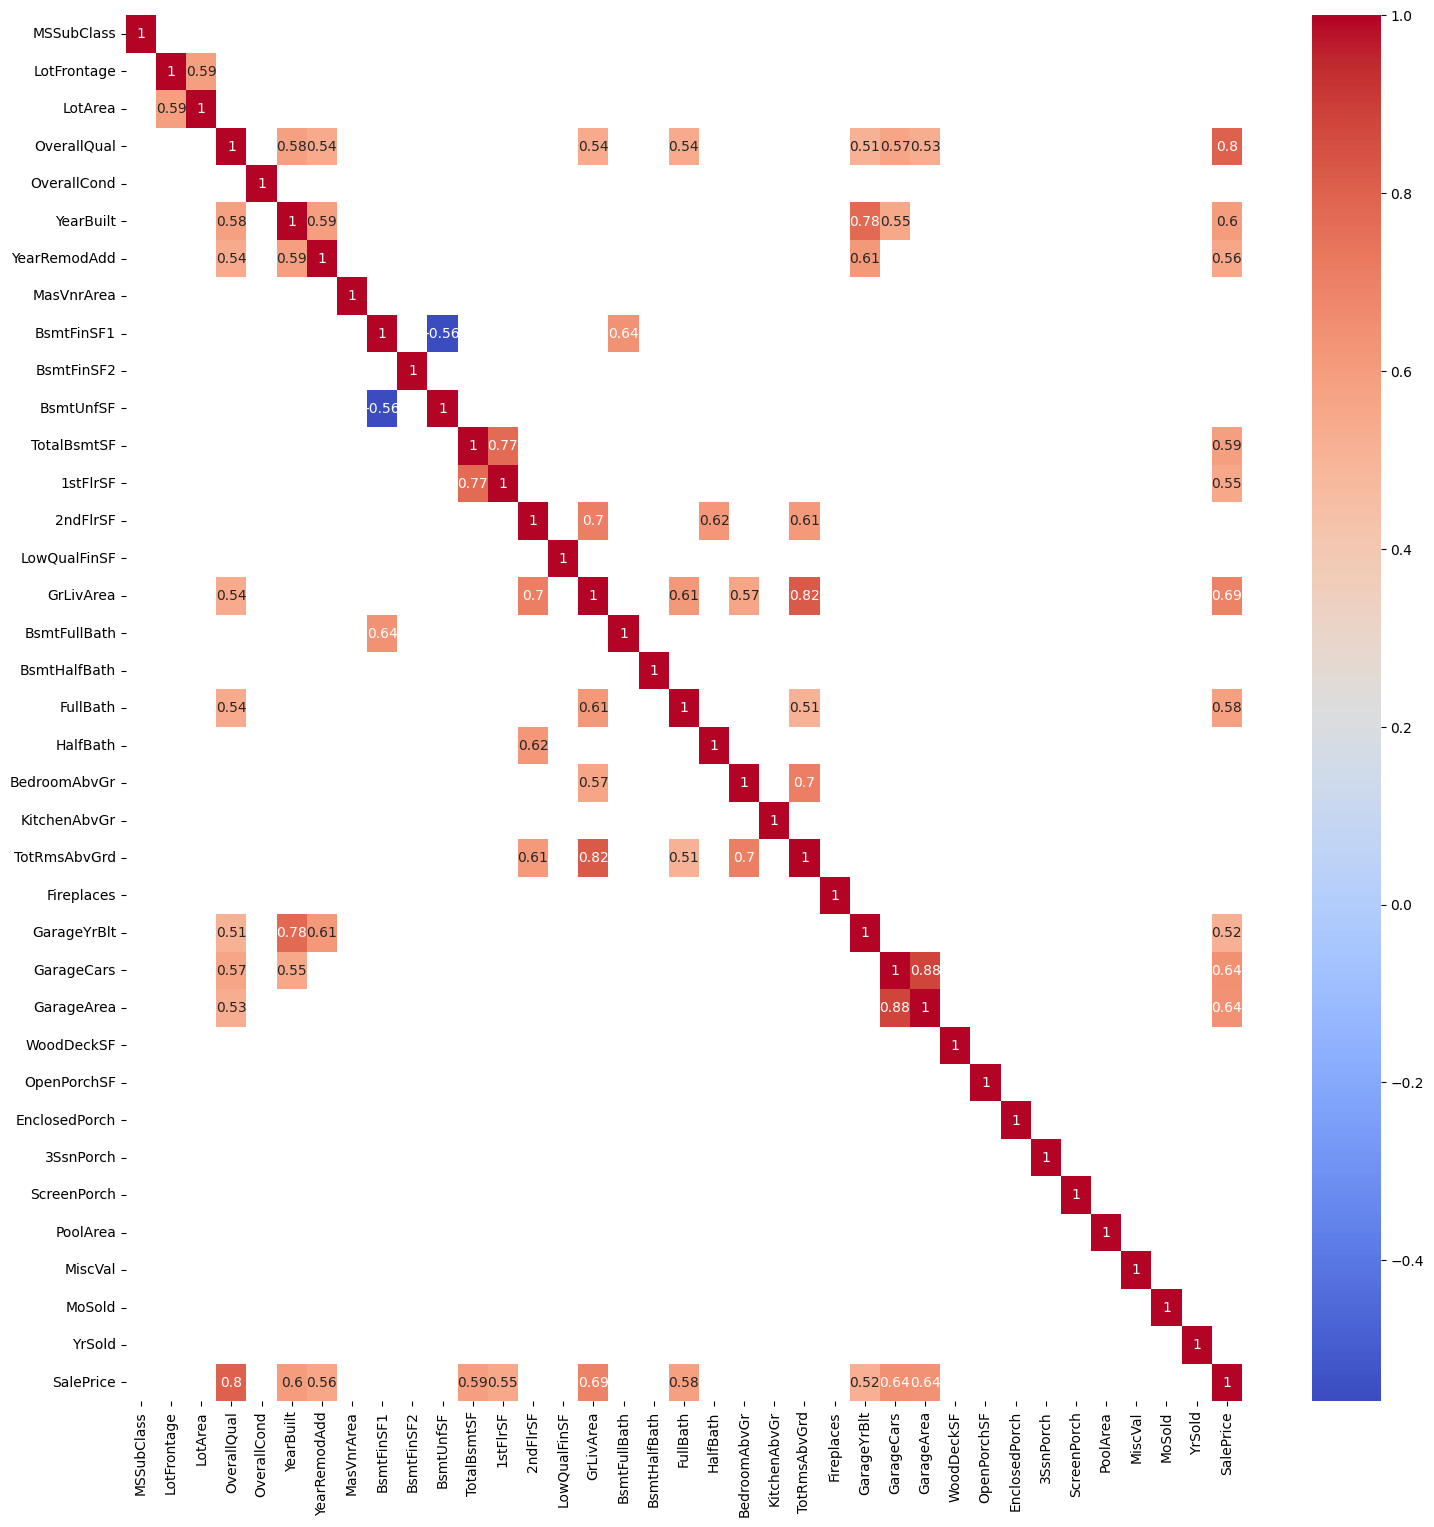

In [14]:
# Select the numerical columns
numerical_columns = trainset.select_dtypes(include=['number'])
# Compute the correlation matrix
correlation_matrix = numerical_columns.corr()
# Create a mask for values outside the desired range
mask = ~((correlation_matrix >= 0.5) | (correlation_matrix <= -0.5))
# Create the heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm')
plt.show()

In [15]:
trainset['YrBlt'] = (trainset['GarageYrBlt'] + trainset['YearBuilt']) / 2
trainset['SF'] = (trainset['TotalBsmtSF'] + trainset['1stFlrSF']) / 2
trainset['Area'] = (trainset['GrLivArea'] + trainset['2ndFlrSF']) / 2
trainset = trainset.drop(['GarageYrBlt', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageCars'], axis = 1)
# Deliberately drop TotRmsAbvGrd and GarageCars

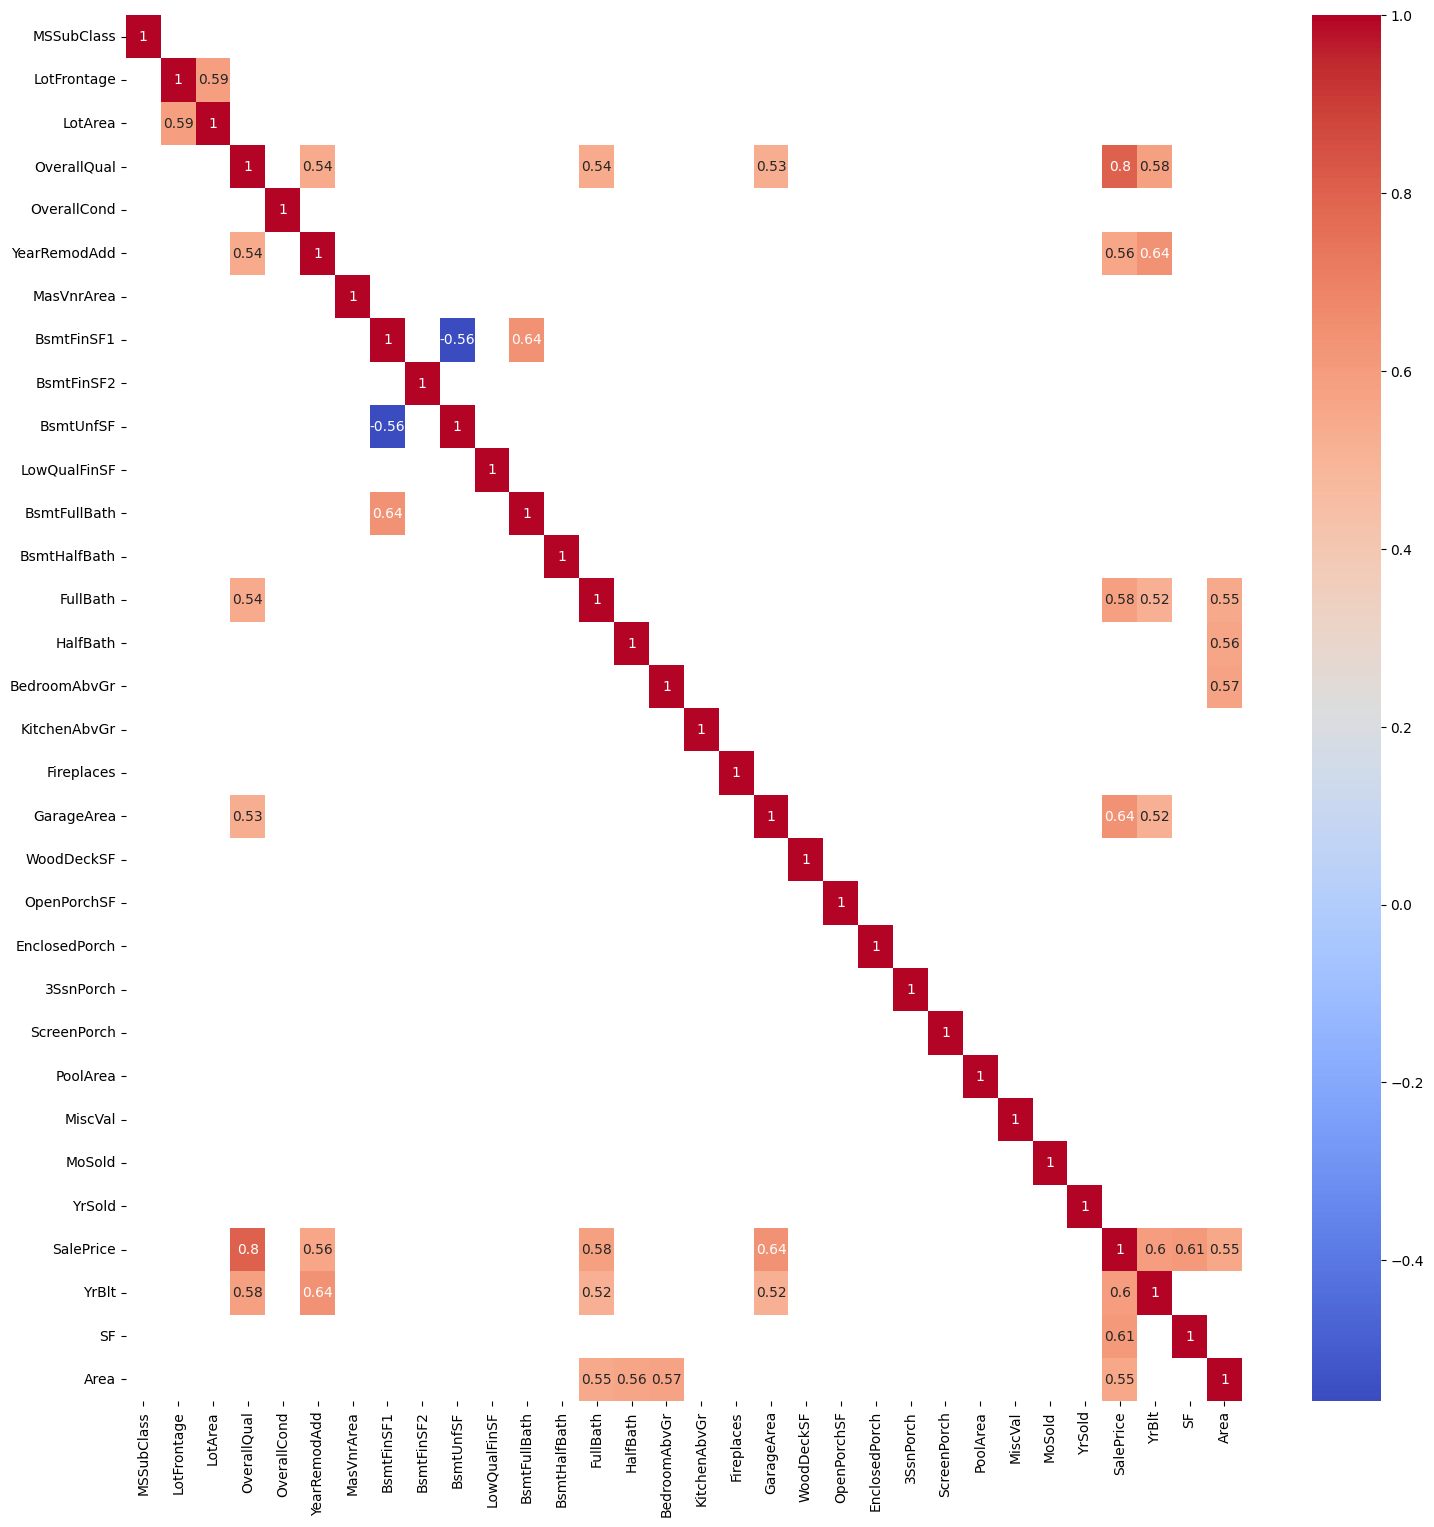

In [16]:
# Check the result of handling multicollinearity
# Select the numerical columns
numerical_columns = trainset.select_dtypes(include=['number'])
# Compute the correlation matrix
correlation_matrix = numerical_columns.corr()
# Create a mask for values outside the desired range
mask = ~((correlation_matrix >= 0.5) | (correlation_matrix <= -0.5))
# Create the heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm')
plt.show()

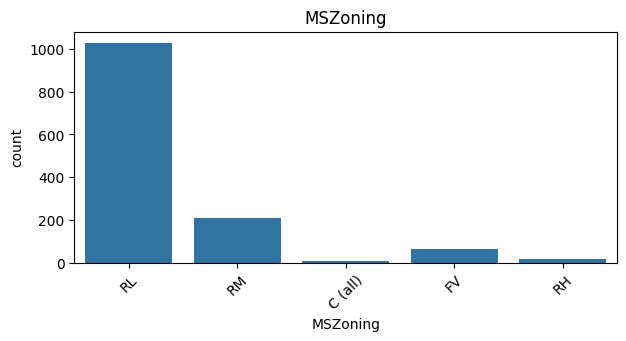

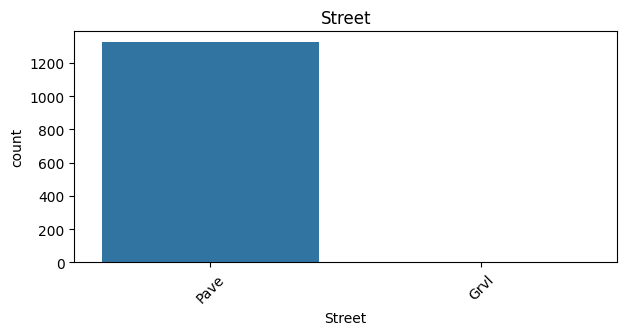

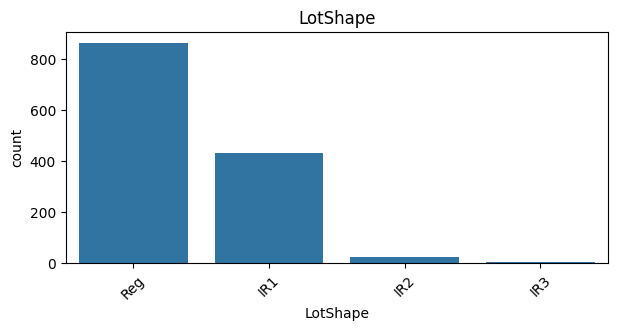

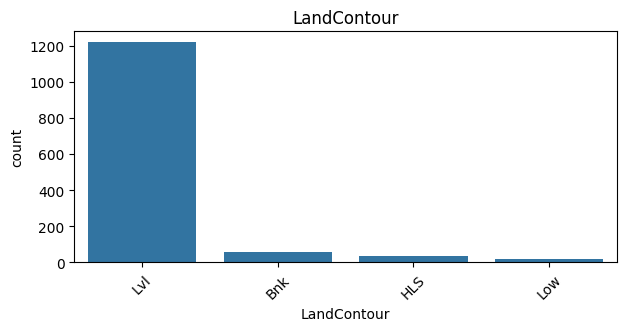

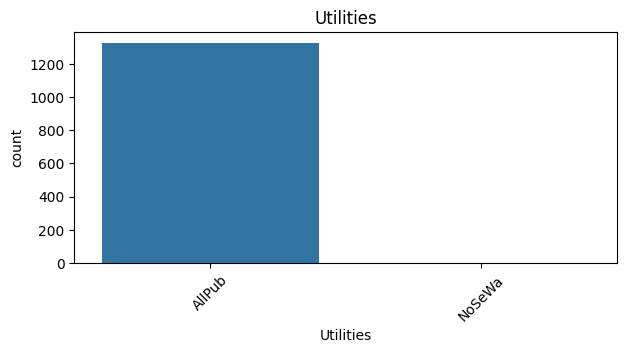

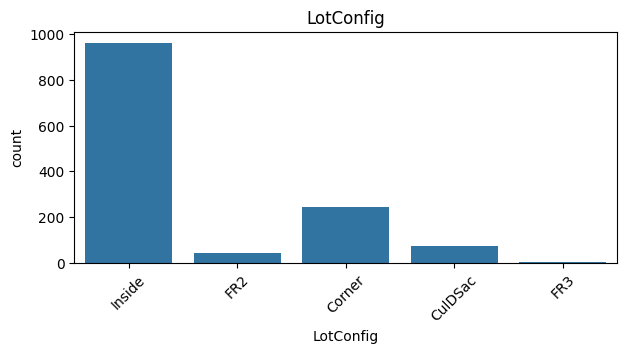

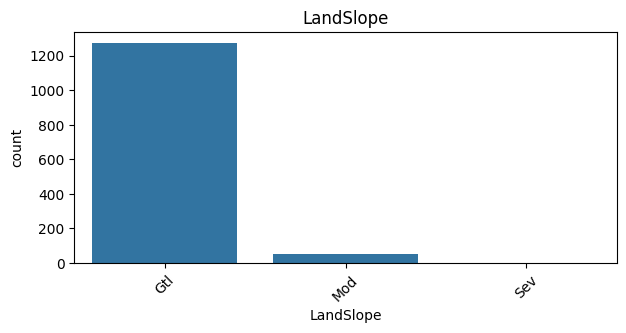

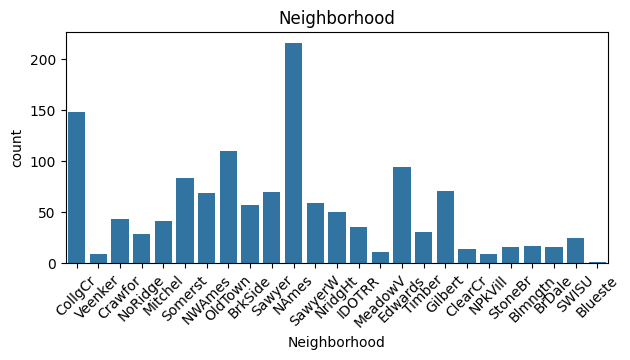

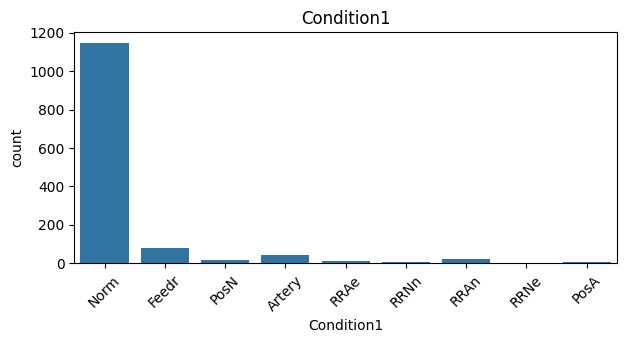

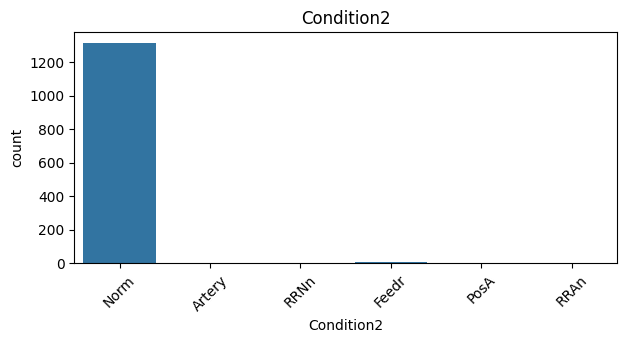

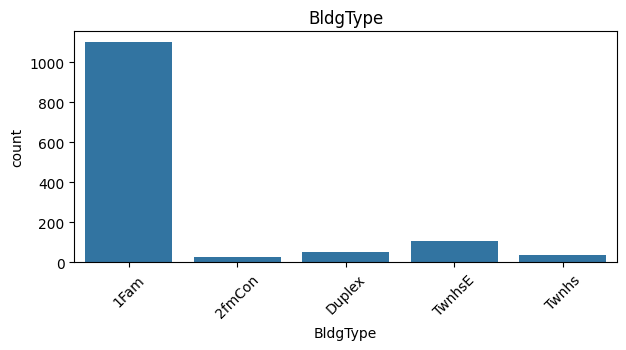

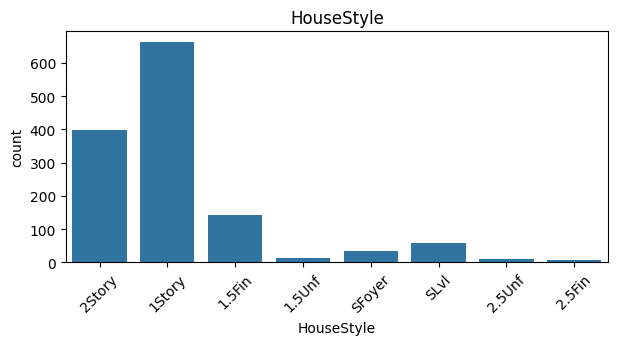

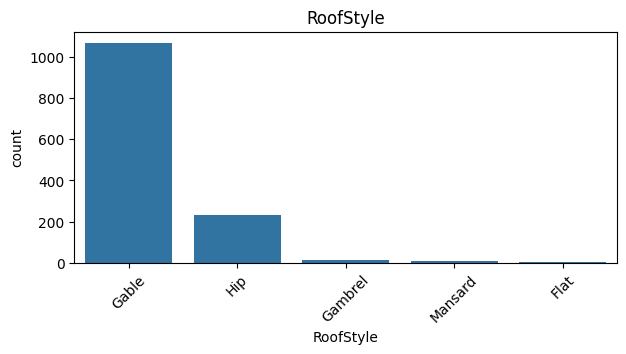

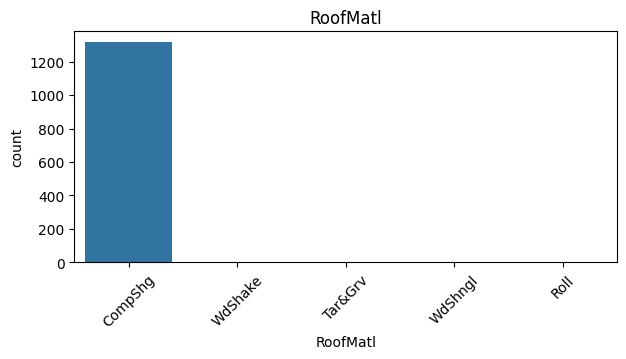

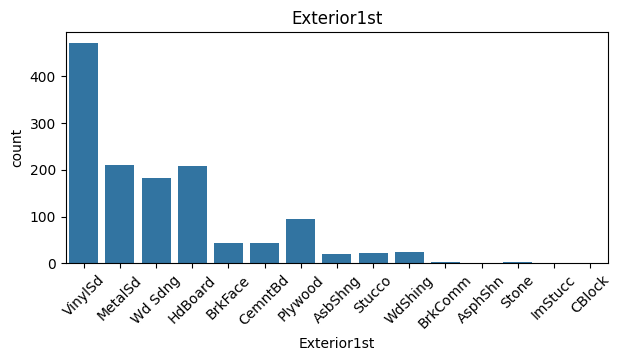

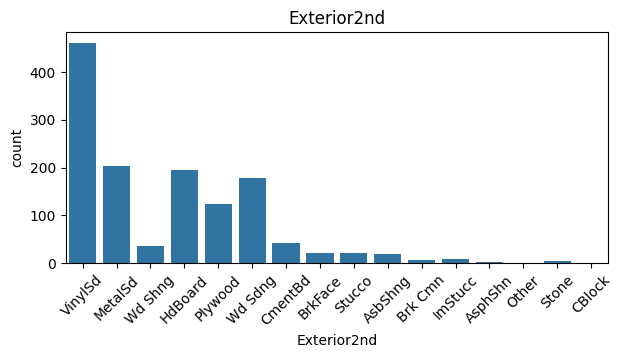

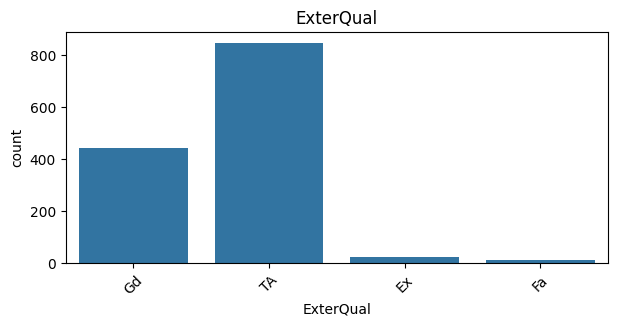

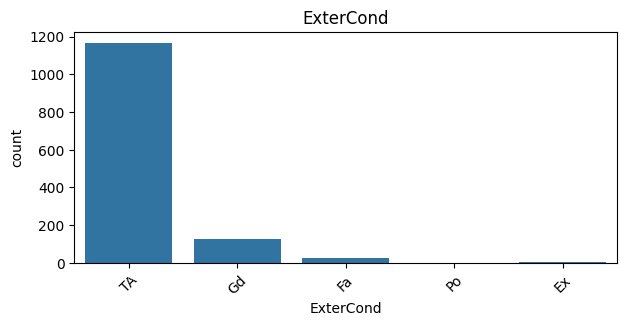

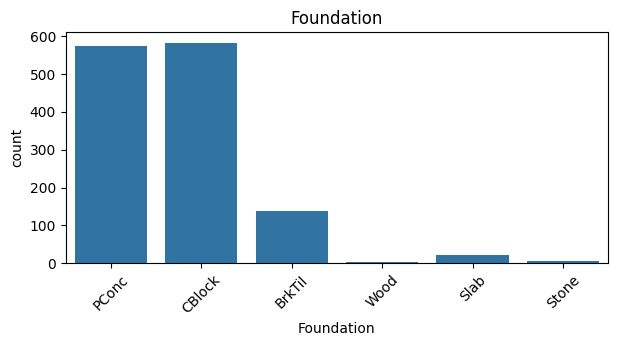

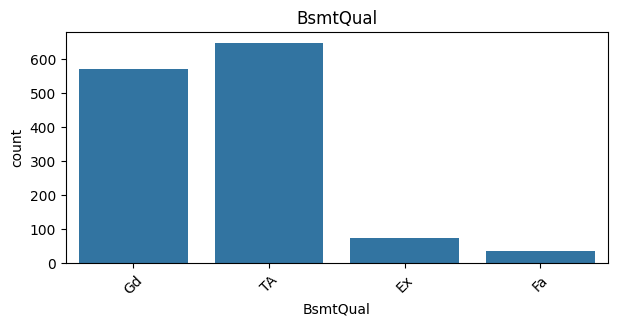

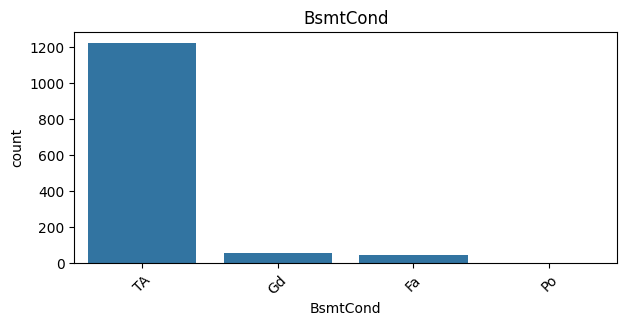

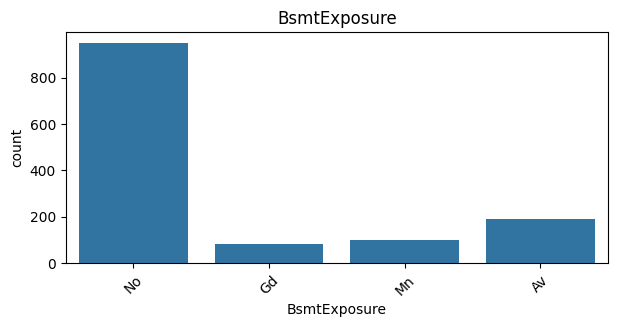

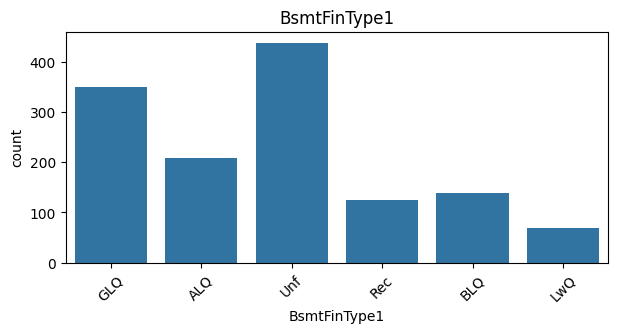

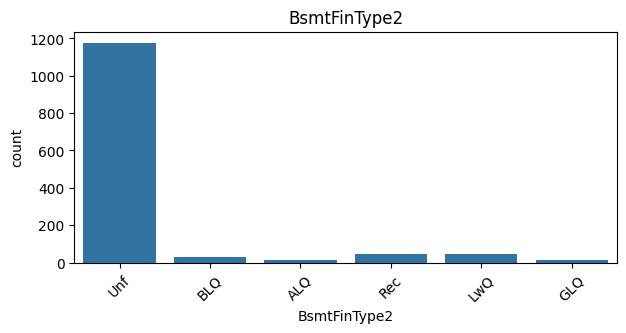

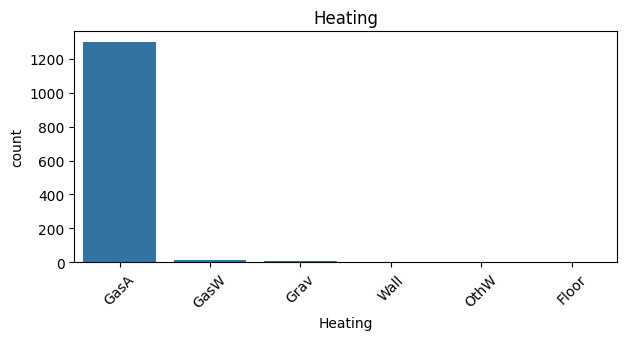

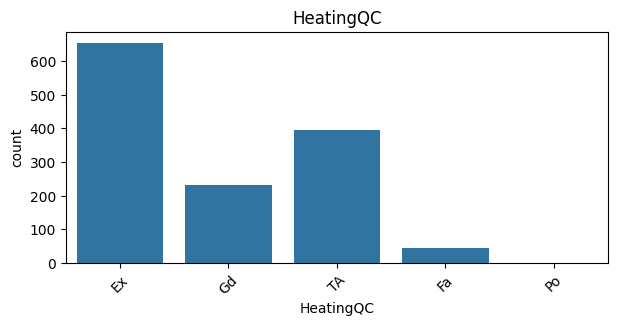

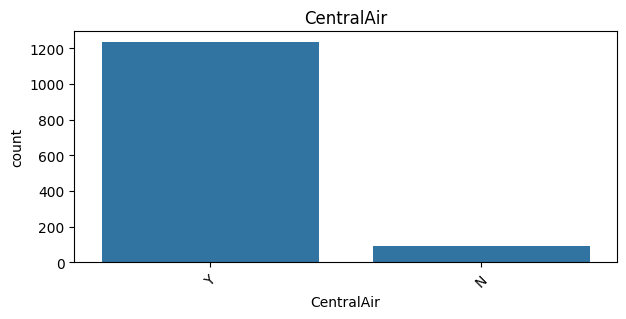

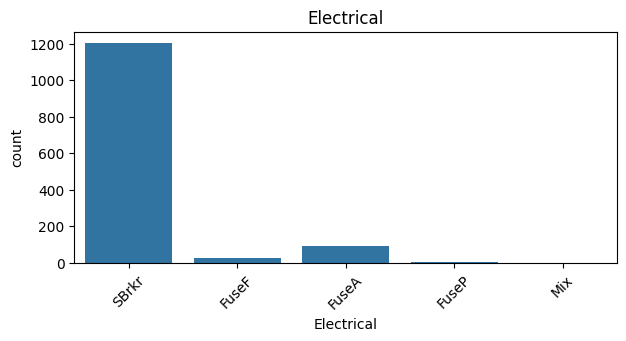

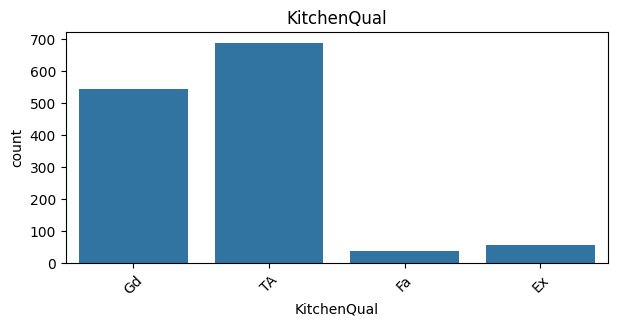

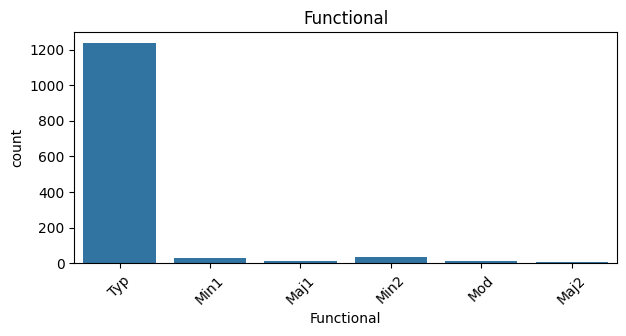

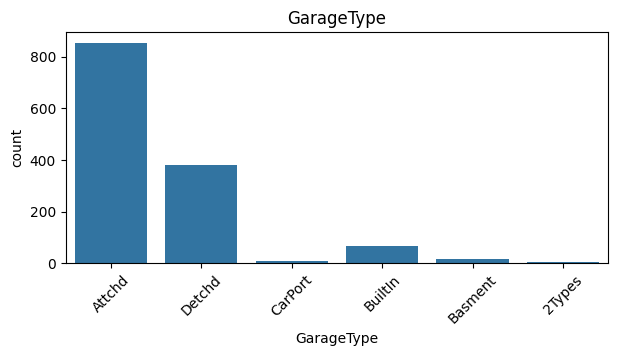

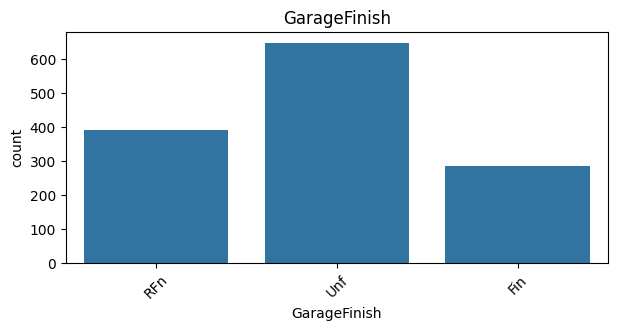

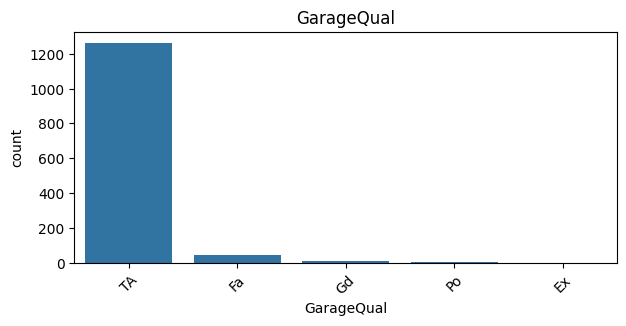

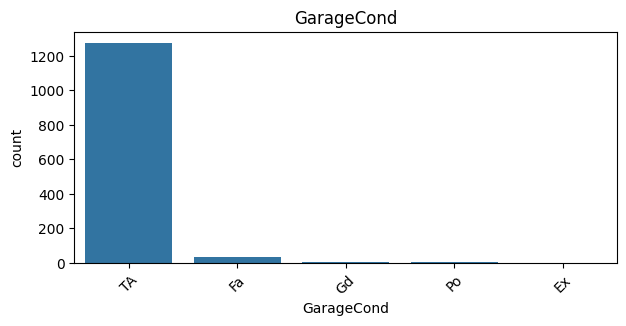

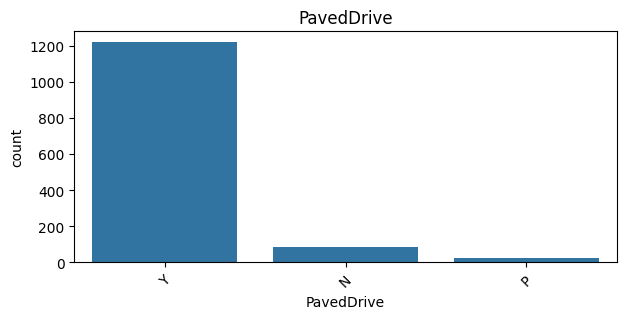

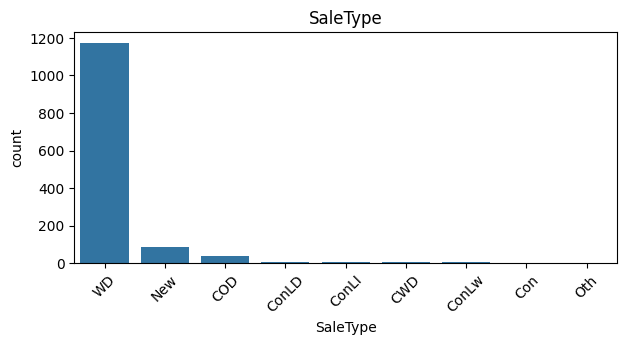

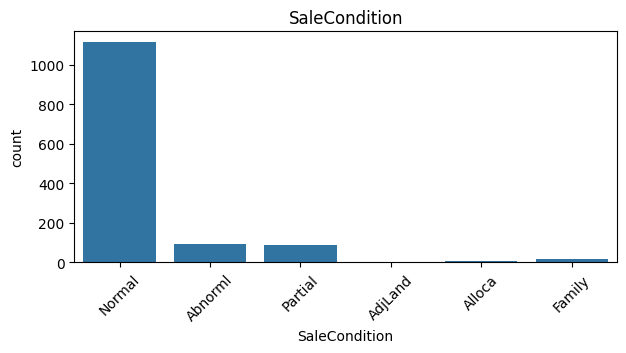

In [17]:
# Draw histograms for categorical features
categorical_columns = trainset.select_dtypes(include=['object'])
for column in categorical_columns:
    plt.figure(figsize=(7, 3))
    sns.countplot(x=column, data=trainset)
    plt.title(column)
    plt.xticks(rotation=45)
    plt.show()


In [18]:
# Drop categorical columns that are less meaningful
trainset.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl'], axis = 1, inplace = True)

In [19]:
# Label encoding for categorical features
labelencoder = LabelEncoder()
for column in trainset.columns:
    if trainset[column].dtypes=='object':
        trainset[column]=labelencoder.fit_transform(trainset[column])

In [20]:
trainset.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YrBlt,SF,Area
0,60,3,65.0,8450,3,3,4,0,5,2,...,0,0,2,2008,8,4,208500,2003.0,856.0,1282.0
1,20,3,80.0,9600,3,3,2,0,24,1,...,0,0,5,2007,8,4,181500,1976.0,1262.0,631.0
2,60,3,68.0,11250,0,3,4,0,5,2,...,0,0,9,2008,8,4,223500,2001.0,920.0,1326.0
3,70,3,60.0,9550,0,3,0,0,6,2,...,0,0,2,2006,8,0,140000,1956.5,858.5,1236.5
4,60,3,84.0,14260,0,3,2,0,15,2,...,0,0,12,2008,8,4,250000,2000.0,1145.0,1625.5


In [21]:
# Create X and target variable y
X = trainset.drop(['SalePrice'], axis = 1)
y = trainset['SalePrice']

In [22]:
# Standardize features
sc = StandardScaler()
X = sc.fit_transform(X)

In [23]:
# Trainset and testset spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [24]:
# Perform forward selection
def forward_selection(X, y, significance_level=0.05):
    initial_features = X.columns.tolist()
    best_features = []
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

feature_names = trainset.drop('SalePrice', axis = 1).columns
X_train_df = pd.DataFrame(X_train, columns = feature_names)
X_train_df.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

selected_features = forward_selection(X_train_df, y_train)
selected_features

['OverallQual',
 'LotArea',
 'GarageArea',
 'Area',
 'SF',
 'YrBlt',
 'BsmtFinSF1',
 'KitchenQual',
 'OverallCond',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'BsmtQual',
 'SaleCondition',
 'Functional',
 'ExterQual',
 'Fireplaces',
 'MSSubClass',
 'BsmtCond',
 'YearRemodAdd',
 'ScreenPorch',
 'BsmtUnfSF',
 'MasVnrArea',
 'MSZoning',
 'HeatingQC',
 'Exterior1st',
 'BsmtFullBath',
 'Foundation',
 'Exterior2nd']

In [25]:
# Build the final regression model
final_model = sm.OLS(y_train, sm.add_constant(X_train_df[selected_features])).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     362.2
Date:                Wed, 20 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:34:01   Log-Likelihood:                -11887.
No. Observations:                1060   AIC:                         2.383e+04
Df Residuals:                    1031   BIC:                         2.398e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.695e+05    560.078    302.605

In [48]:
X_test_df = pd.DataFrame(X_test, columns = feature_names)
X_test_df.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Predict using the test set
y_pred_ols = final_model.predict(sm.add_constant(X_test_df[selected_features]))

# Evaluate the predictions
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols = r2_score(y_test,y_pred_ols)

print(f"Root Mean Squared Error: {rmse_ols}")
print(f"R-squared: {r2_ols}")

Root Mean Squared Error: 19487.924997051407
R-squared: 0.8824779824803255


In [50]:
model_lr = LinearRegression()
model_lr.fit(X_train_df[selected_features], y_train)
# Make predictions on the test set
y_pred_lr = model_lr.predict(X_test_df[selected_features])
# Calculate metrics
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Root Mean Squared Error: {rmse_lr}")
print(f"R-squared: {r2_lr}")

Root Mean Squared Error: 19487.92499705142
R-squared: 0.8824779824803253


In [51]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train_df[selected_features], y_train)
y_pred_rfr = model_rfr.predict(X_test_df[selected_features])
# Calculate mean squared error
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
r2_rfr = r2_score(y_test, y_pred_rfr)

print(f"Root Mean Squared Error: {rmse_rfr}")
print(f"R-squared: {r2_rfr}")

Root Mean Squared Error: 22258.564371152068
R-squared: 0.8466858148285323


In [52]:
xgb_param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the base model
model_xgbr = XGBRegressor()

# Initialize RandomizedSearchCV
random_search_xgbr = RandomizedSearchCV(
    estimator=model_xgbr, 
    param_distributions=xgb_param_grid, 
    n_iter=100,  # Number of parameter settings sampled. Increase or decrease based on computational resource.
    scoring='neg_mean_squared_error', 
    cv=3,  # Number of folds in cross-validation
    verbose=1, 
    random_state=42,
    n_jobs=-1  # Number of jobs to run in parallel
)

random_search_xgbr.fit(X_train_df[selected_features], y_train)
best_model_xgbr = random_search_xgbr.best_estimator_

# Make predictions using the best model
y_pred_xgbr = best_model_xgbr.predict(X_test_df[selected_features])

# Calculate metrics
rmse_xgbr = np.sqrt(mean_squared_error(y_test, y_pred_xgbr))
r2_xgbr = r2_score(y_test, y_pred_xgbr)

print(f"Root Mean Squared Error: {rmse_xgbr}")
print(f"R-squared: {r2_xgbr}")



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Root Mean Squared Error: 19150.905251360422
R-squared: 0.8865076327541475


In [53]:
lgbmr_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'num_leaves': [20, 31, 40],  # Larger number increases complexity of the model
    'max_depth': [-1, 5, 10],  # -1 means no limit
    'min_child_samples': [10, 20, 30]
}

# Initialize the base model
model_lgbmr = LGBMRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_lgbmr = RandomizedSearchCV(
    estimator=model_lgbmr, 
    param_distributions=lgbmr_param_grid, 
    n_iter=100,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error', 
    cv=3,  # Number of folds in cross-validation
    verbose=1, 
    random_state=42,
    n_jobs=-1  # Number of jobs to run in parallel
)

random_search_lgbmr.fit(X_train_df[selected_features], y_train)

best_model_lgbmr = random_search_lgbmr.best_estimator_

# Make predictions using the best model
y_pred_lgbmr = best_model_lgbmr.predict(X_test_df[selected_features])

# Calculate metrics
rmse_lgbmr = np.sqrt(mean_squared_error(y_test, y_pred_lgbmr))
r2_lgbmr = r2_score(y_test, y_pred_lgbmr)

print(f"Root Mean Squared Error: {rmse_lgbmr}")
print(f"R-squared: {r2_lgbmr}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 1060, number of used features: 28
[LightGBM] [Info] Start training from score 169640.650943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [54]:
print(f'RMSE_LR: {rmse_lr:.2f}')
print(f'RMSE_RFR: {rmse_rfr:.2f}')
print(f'RMSE_XGBR: {rmse_xgbr:.2f}')
print(f'RMSE_LGBMR: {rmse_lgbmr:.2f}')
print('---------------------')
print(f'R2_LR: {r2_lr:.2f}')
print(f'R2_RFR: {r2_rfr:.2f}')
print(f'R2_XGBR: {r2_xgbr:.2f}')
print(f'R2_LGBMR: {r2_lgbmr:.2f}')

RMSE_LR: 19487.92
RMSE_RFR: 22258.56
RMSE_XGBR: 19150.91
RMSE_LGBMR: 19921.15
---------------------
R2_LR: 0.88
R2_RFR: 0.85
R2_XGBR: 0.89
R2_LGBMR: 0.88


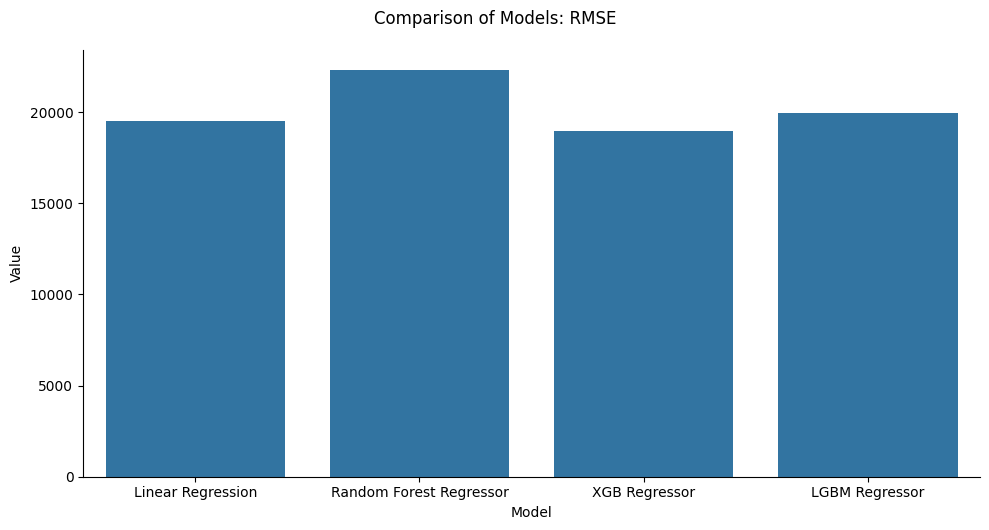

In [32]:
# Compare models
# Data for comparison
data = {
    'Model': ['Linear Regression', 'Random Forest Regressor', 'XGB Regressor', 'LGBM Regressor'],
    'Value': [rmse_lr, rmse_rfr, rmse_xgbr, rmse_lgbmr]
}

compare_df = pd.DataFrame(data)

g = sns.catplot(
    x='Model', 
    y='Value', 
    data=compare_df, 
    kind='bar', 
    height=5, 
    aspect=2
)

g.set_axis_labels("Model", "Value")
g.fig.suptitle('Comparison of Models: RMSE', y=1.05)

plt.show()

In [68]:
# Preprocessing for the testset

# Drop columns
testset.drop(['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Street', 'Utilities', 'Condition2', 'RoofMatl'], axis = 1, inplace = True)

# Impute missing values
for column in testset.columns:
    if testset[column].dtype == 'object':
        testset[column] = testset[column].fillna(testset[column].mode()[0])
    else:
        testset[column] = testset[column].fillna(testset[column].mean())
        

# Handle multicollinearity
testset['YrBlt'] = (testset['GarageYrBlt'] + testset['YearBuilt']) / 2
testset['SF'] = (testset['TotalBsmtSF'] + testset['1stFlrSF']) / 2
testset['Area'] = (testset['GrLivArea'] + testset['2ndFlrSF']) / 2
testset = testset.drop(['GarageYrBlt', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageCars'], axis = 1)

# Select columns based on best features
submission = testset[['Id']]
testset = testset[selected_features]

# Label encoding
# Label encoding for categorical features
labelencoder = LabelEncoder()
for column in testset.columns:
    if testset[column].dtypes=='object':
        testset[column]=labelencoder.fit_transform(testset[column])
        
# Standardize features
sc = StandardScaler()
testset = sc.fit_transform(testset)

In [69]:
y_pred = best_model_xgbr.predict(testset)

In [70]:
submission['SalePrice'] = y_pred

In [71]:
submission.to_csv(project_dir + 'submission.csv', index = False)

In [67]:
testset.shape

(1459, 80)